# EDS 220 Fall 2022
# NDVI Calculations with Landsat Data

Now that we've gotten somewhat familiar with using Google Earth Engine to do basic data visualizations, in this notebook we'll apply our tools to a new spectral index. As we did in class, we'll be working with the Landsat data catalog:

https://developers.google.com/earth-engine/datasets/catalog/landsat

The ultimate goal here is to read in Landsat multispectral data and use it to calculate a standard 'index' product used to indicate vegetation health: the [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index). Here are some example maps showing the surface reflectance sensed by Landsat (left) and the NDVI index calculated from those data (right):

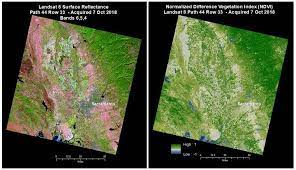

The NDVI is calculated using the red (R) and near-infrared (NIR) bands, combined using the following formula: 

### $NDVI = \frac{(NIR - R)}{(NIR + R)}$

A more detailed description is available on the USGS Landsat website:

https://www.usgs.gov/core-science-systems/nli/landsat/landsat-normalized-difference-vegetation-index?qt-science_support_page_related_con=0#qt-science_support_page_related_con

## Configure Your Environment

As we did in the class example (Landsat_colormaps_GEE), we'll need to set up our Jupyter environment and make sure that GEE is authenticated and initialized. The packages we need are `ee`, `geemap`, and `pandas`:

In [1]:
# Import necessary packages
import ee
import geemap
import pandas as pd

# Authenticate and initialize Google Earth Engine
#ee.Authenticate()
ee.Initialize()

We'll work with Landsat 8 data from the Tier 1-Real Time dataset, to ensure high quality and long temporal coverage. As a reminder, the differences between the Landsat data 'tiers' is:

   - **Tier 1** data are considered high-quality
   - **Tier 2** data don't pass muster to get into Tier 1
   - **Real-Time (RT)** data haven't been processed into either tier yet
    
A full description of the Landsat data organizational structure in GEE can be found at: https://developers.google.com/earth-engine/guides/landsat

The below example reads in data from:

 - The Landsat 8 mission (LC08)
 - Data Collection 1 (C01); this is the first "official" collection of Landsat data ingested into GEE, which will eventually be superseded by Collection 2 but will be maintained through the end of 2022
 - Tier 1 data (T1), the highest data quality 
 
Note that the data we will be reading in here are _top-of-atmosphere (TOA) reflectances_, estimates of the radiation reflected at the top of Earth's atmosphere.

The first thing we'll do is to read in the Tier 1-Real Time dataset, using the `ee.ImageCollection` function:

In [2]:
# Load Landsat 8 Tier 1 Real Time data
gdat = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA')

In [4]:
# Filter to images overlapping Santa Barbara
pt = ee.Geometry.Point([-119.69, 34.42])   # Point corresponding to Santa Barbara, CA
                                           # NOTE: syntax for ee.Geometry.Point is [longitude, latitude]

gdat_filt = gdat.filterBounds(pt)

In [5]:
# Use filter to extract all "non-cloudy" images: ones with less than 20% cloud cover
dat_nocld=gdat_filt.filter('CLOUD_COVER < 0.2')

## Calculate NDVI

Technically, arithmetic operations in GEE must be performed on individual Image objects - so if you try to add or subtract ImageCollections directly, an error will result (you can try it if you want, and see what I mean!). There are two ways around this:
 1. Filter the ImageCollection down to a single Image, then perform calculations
 2. Use the `map()` function to perform calculations on each image within the collection
 
Below are examples using both these methods:
 
**Option 1: Filter ImageCollection down to a single Image**

We can follow the procedure used in class to create a temporal average of Landsat imagery over a given time period; this will be a single image, which we can use to compute NDVI.

In [6]:
# Command to extract all data over appropriate time, perform temporal averaging
dat_drght=dat_nocld.filter(ee.Filter.date('2017-12-10', '2018-12-31')).mean();

For NDVI calculation, we want bands 4 (red) and 5 (NIR), which are called "B4" and "B5" respectively.

In order to perform the actual calculation, we need to use the `subtract`, `add`, and `divide` attributes:

In [7]:
red = dat_drght.select('B4')
nir = dat_drght.select('B5')

ndvi=(nir.subtract(red)).divide((nir.add(red))).rename('NDVI')


Now we define new visualization parameters appropriate for NDVI. Since this index is based on a difference between bands, it now has a range between -1 and 1, rather than the values one uses when generating a true-color image.

One other neat thing you can do when specifying visualization parameters is assign different color palettes: here I'm specifying a color bar that ranges from blue (negative NDVI) to green (positive NDVI), with white in the middle.

In [8]:
ndviParams = {'min': -1, 
              'max': 1, 
              'palette': ['blue', 'white', 'green']
             }

Then all there is to do is to create a basemap and add the NDVI layer to it!

In [12]:
# Plot a blank version of the selected basemap
# NOTE: syntax for geemap.Map is "center=[latitude, longitude]"
Map = geemap.Map(center=[34.42, -119.69], zoom=8)
Map

Map(center=[34.42, -119.69], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [13]:
# Add NDVI to basemap
Map.addLayer(ndvi, ndviParams,'NDVI')

**Option 2: Mapping NDVI across an ImageCollection**

The next example uses `map()` so that we can get familiar with how it works. First, we define a function which takes an image as input: it then calculates NDVI and adds it to the image as a new band called "NDVI". Here is the function:

In [14]:
# Function to calculate NDVI for a given input image
def addNDVI(image):
    red = image.select('B4')
    nir = image.select('B5')
    
    ndvi = (nir.subtract(red)).divide((nir.add(red))).rename('NDVI')
    
    return image.addBands(ndvi)

Now we can use this function in the call to "map" and apply it to the entire collection of Santa Barbara images:

In [15]:
# Apply 'map' to add NDVI to Landsat image collection
gdat_withndvi = gdat_filt.map(addNDVI)

We'll need to specify new visualization parameters, which tell GEE to plot the new `NDVI` band in the appropriate color range:

In [18]:
ndviParams = {'bands': 'NDVI',
              'min': -1, 
              'max': 1, 
              'palette': ['blue', 'white', 'green']
             }

Finally, we use the same approach as above to plot the NDVI layer over the basemap:

In [16]:
# Create and plot basemap
Map = geemap.Map(center=[34.42, -119.69], zoom=8)
Map

Map(center=[34.42, -119.69], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [19]:
Map.addLayer(gdat_withndvi, ndviParams)

If you look at the above map, you'll see that rather than the single (temporal average) image that Option 1 generates, Option 2 is actually plotting many images superimposed on one another!